In [2]:
!pip install qiskit==1.2.0 qiskit_machine_learning

  Using cached qiskit-1.2.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit_machine_learning-0.8.2-py3-none-any.whl.metadata (13 kB)
  Using cached rustworkx-0.16.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.4.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pbr-6.1.1-py2.py3-none-any.whl.metadata (3.4 kB)
  Usin

In [3]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from qiskit_machine_learning.algorithms import QSVR
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [5]:
def load_and_preprocess_data(file_path, date_column, target_column, garbage_columns):
    df = pd.read_excel(file_path)
    df = df.drop(columns=garbage_columns)
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)
    return df, df.columns.get_loc(target_column)
    # pass

In [6]:
def visualize_data(df, target_column):
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df[target_column], label=target_column)
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.title(f'{target_column} Data')
    plt.legend()
    plt.show()

In [7]:
def split_data(df, train_start, test_start):
    train = df.loc[train_start:test_start]
    test = df.loc[test_start:]
    return train, test

In [26]:
def scale_data(data_train, data_test, train_vars, target_id):
    scaler_feature = MinMaxScaler()
    scaler_target = MinMaxScaler()
    train_scaled = scaler_feature.fit_transform(data_train.iloc[:, train_vars])
    train_target = scaler_target.fit_transform(data_train.iloc[:, target_id].to_frame())
    test_scaled = scaler_feature.transform(data_test.iloc[:, train_vars])
    test_target = scaler_target.transform(data_test.iloc[:, target_id].to_frame())
    return (train_scaled, train_target), (test_scaled, test_target), (scaler_feature, scaler_target)

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
def train_qsvr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05, kernel = None):
    model = QSVR(quantum_kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1))
    return model

def train_svr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05):
    model = SVR(gamma=gamma, C=C, epsilon=epsilon)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1))
    return model

In [43]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
    test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

    train_pred_inv = scaler[1].inverse_transform(train_pred.reshape(-1, 1))
    y_train_inv = scaler[1].inverse_transform(y_train.reshape(-1, 1))
    test_pred_inv = scaler[1].inverse_transform(test_pred.reshape(-1, 1))
    y_test_inv = scaler[1].inverse_transform(y_test.reshape(-1, 1))

    mse_train = mean_squared_error(y_train_inv, train_pred_inv)
    mse_test = mean_squared_error(y_test_inv, test_pred_inv)

    print("Mean Squared Error on Training Data:", mse_train)
    print("Mean Squared Error on Testing Data:", mse_test)

    return train_pred_inv, y_train_inv, test_pred_inv, y_test_inv

In [65]:
def plot_results(train, test, train_pred_inv, y_train_inv, test_pred_inv, y_test_inv, time_steps):
    plt.figure(figsize=(15, 8))
    plt.plot(train.index[:-1], y_train_inv, label='Original (Train)', color='darkgreen')
    plt.plot(train.index[:-1], train_pred_inv, label='Predicted (Train)', color='red')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.title('Training Dataset Results')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.plot(test.index[:-1], y_test_inv, label='Original (Test)', color='darkgreen')
    plt.plot(test.index[:-1], test_pred_inv, label='Predicted (Test)', color='red')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.title('Testing Dataset Results')
    plt.legend()
    plt.show()

#Data prep

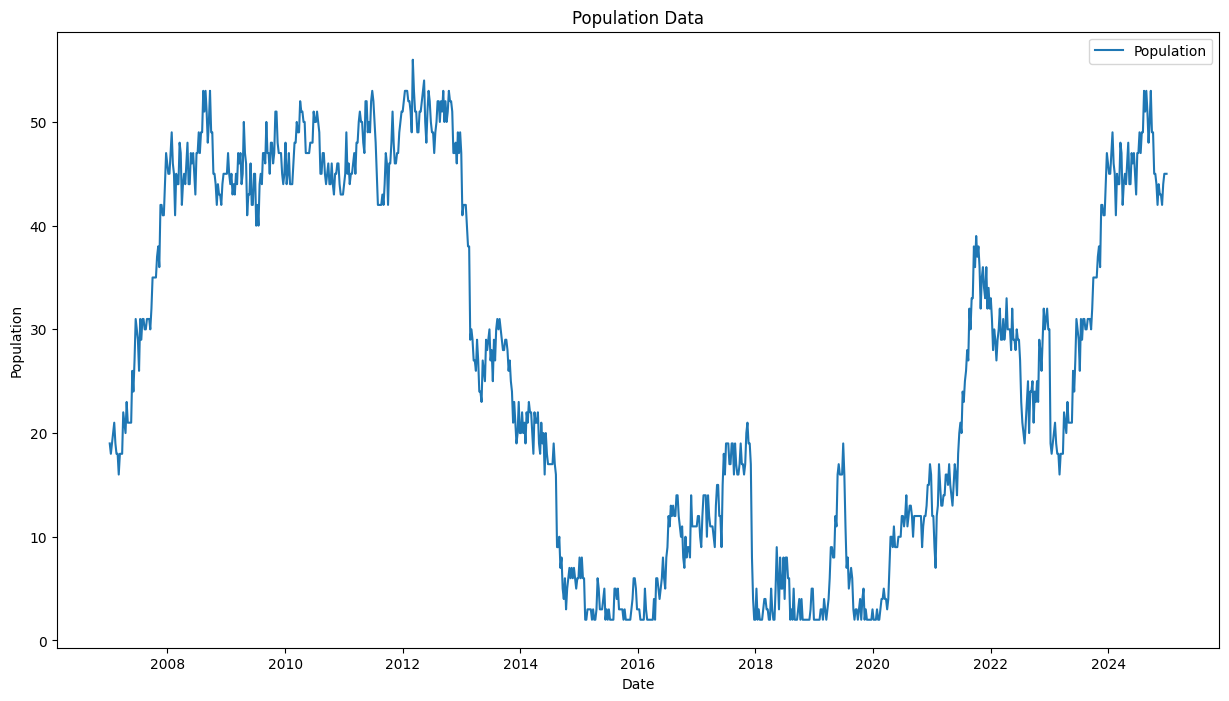

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 939 entries, 2007-01-07 07:52:42 to 2024-12-29 06:14:56
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Population              939 non-null    int64  
 1   10m u wind              939 non-null    float64
 2   10m v wind              939 non-null    float64
 3   2m temp                 939 non-null    float64
 4   avg sea level pressure  939 non-null    float64
 5   surface pressure        939 non-null    float64
 6   total precipitation     939 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 58.7 KB
None
(104, 1, 6) (104, 1) [1, 2, 3, 4, 5, 6]
(51, 1, 6) (51, 1)


In [92]:
# Main execution
file_path = 'ArabianGhezzel_WeeklyTimestamps_2007to2024.xlsx'  # Replace with your dataset path
date_column = 'Timestamp'  # Replace with your date column name
target_column = 'Population'  # Replace with your target column name
garbage_columns = ['Region']
train_start = '2022-01-01'  # Replace with your training start date
test_start = '2024-01-01'  # Replace with your testing start date
time_steps = 1

# Load and preprocess data
df, target_id = load_and_preprocess_data(file_path, date_column, target_column, garbage_columns)
visualize_data(df, target_column)

print(df.info())

# Getting trin variables
train_vars = list(range(df.columns.shape[0]))
train_vars.remove(target_id)

# Split data
train, test = split_data(df, train_start, test_start)

# Scale data
train_scaled, test_scaled, scaler = scale_data(train, test, train_vars, target_id)

# print(target_id, train, train_scaled)


# Prepare data for training
X_train, y_train = create_dataset(train_scaled[0], train_scaled[1], time_steps)
X_test, y_test = create_dataset(test_scaled[0], test_scaled[1], time_steps)

print(X_train.shape, y_train.shape, train_vars)
print(X_test.shape, y_test.shape)

#Train

In [85]:
# kernel
feature_map = ZZFeatureMap(feature_dimension=6*time_steps, reps=1)
qkernel = FidelityQuantumKernel(feature_map=feature_map, enforce_psd=False)

print(feature_map.decompose())


     ┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_4: ┤ H ├┤ P(2.0*x[4]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_5: ┤ H ├┤ P(2.0*x[5]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«                                     

In [86]:
# Train model
model_q = train_qsvr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05, kernel = qkernel)

In [87]:
model_c = train_svr_model(X_train, y_train, gamma=0.5, C=10, epsilon=0.05)

#Test

In [90]:
# Evaluate model
def test_fun(model):
    train_pred_inv, y_train_inv, test_pred_inv, y_test_inv = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
    print(test_pred_inv.shape, y_test_inv.shape)
    # Plot results
    plot_results(train, test, train_pred_inv, y_train_inv, test_pred_inv, y_test_inv, time_steps)

Mean Squared Error on Training Data: 2.1071538014299387
Mean Squared Error on Testing Data: 378.9531819406331
(51, 1) (51, 1)


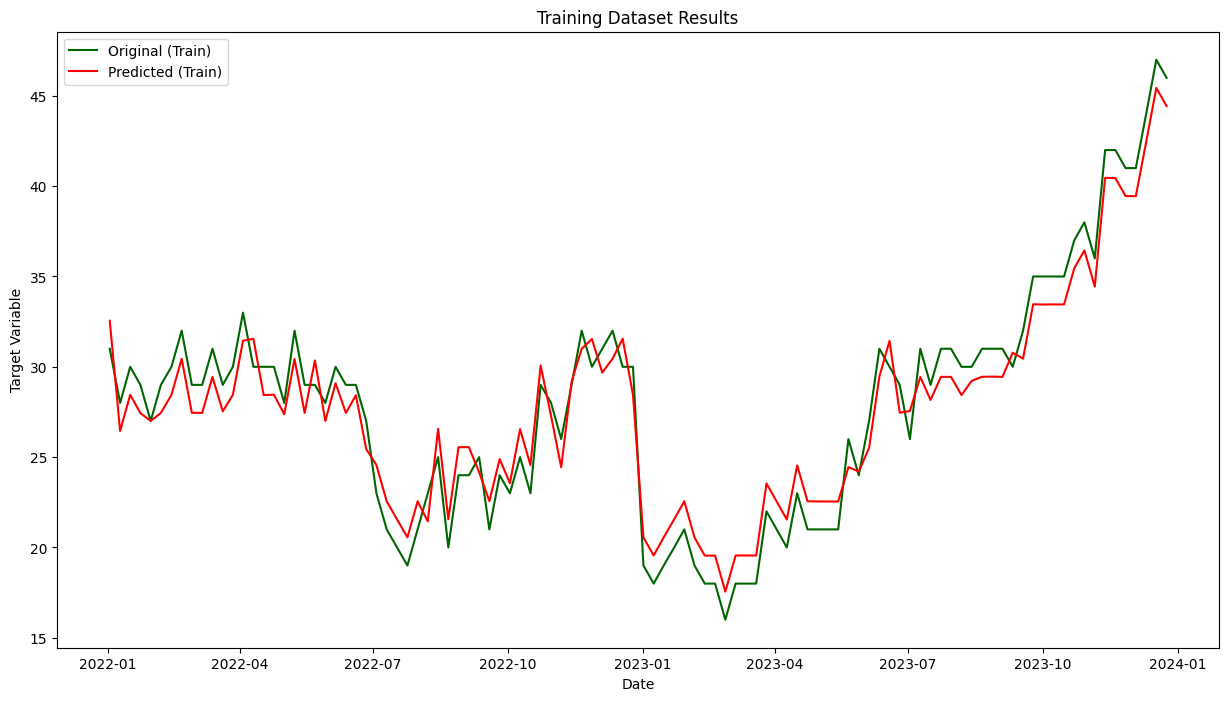

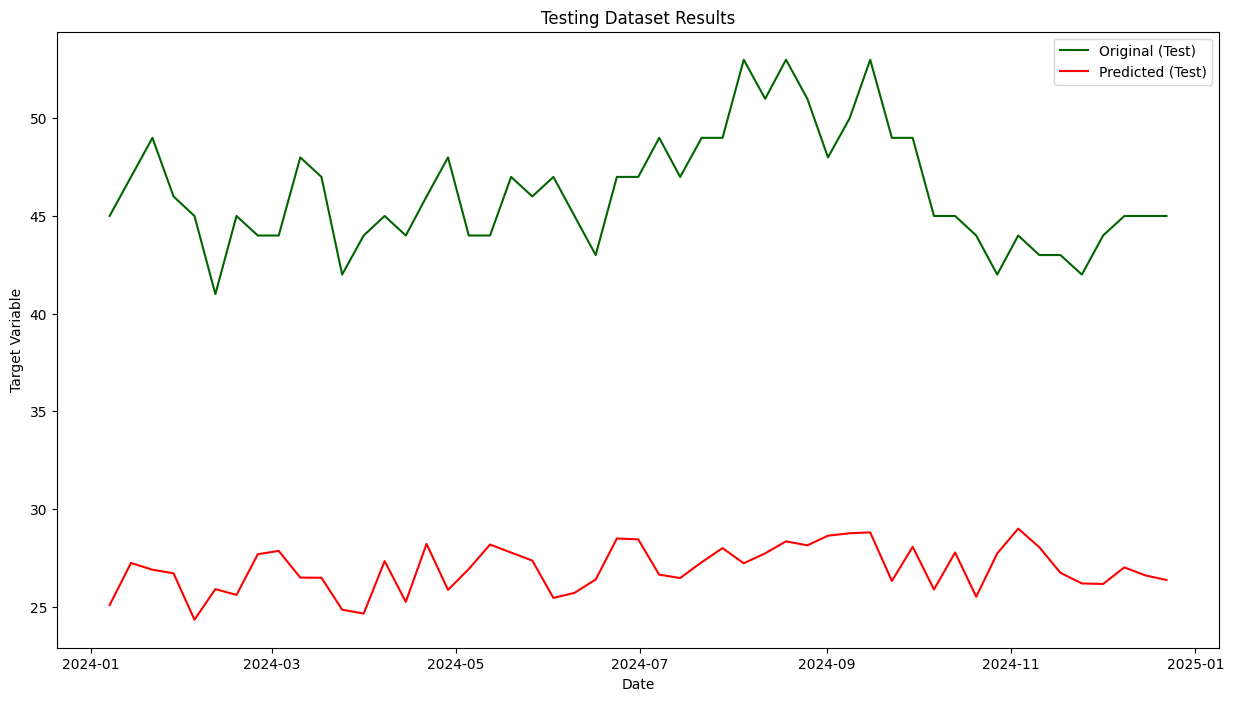

In [94]:
test_fun(model_q)

Mean Squared Error on Training Data: 28.72745584550707
Mean Squared Error on Testing Data: 1090.950089561887
(51, 1) (51, 1)


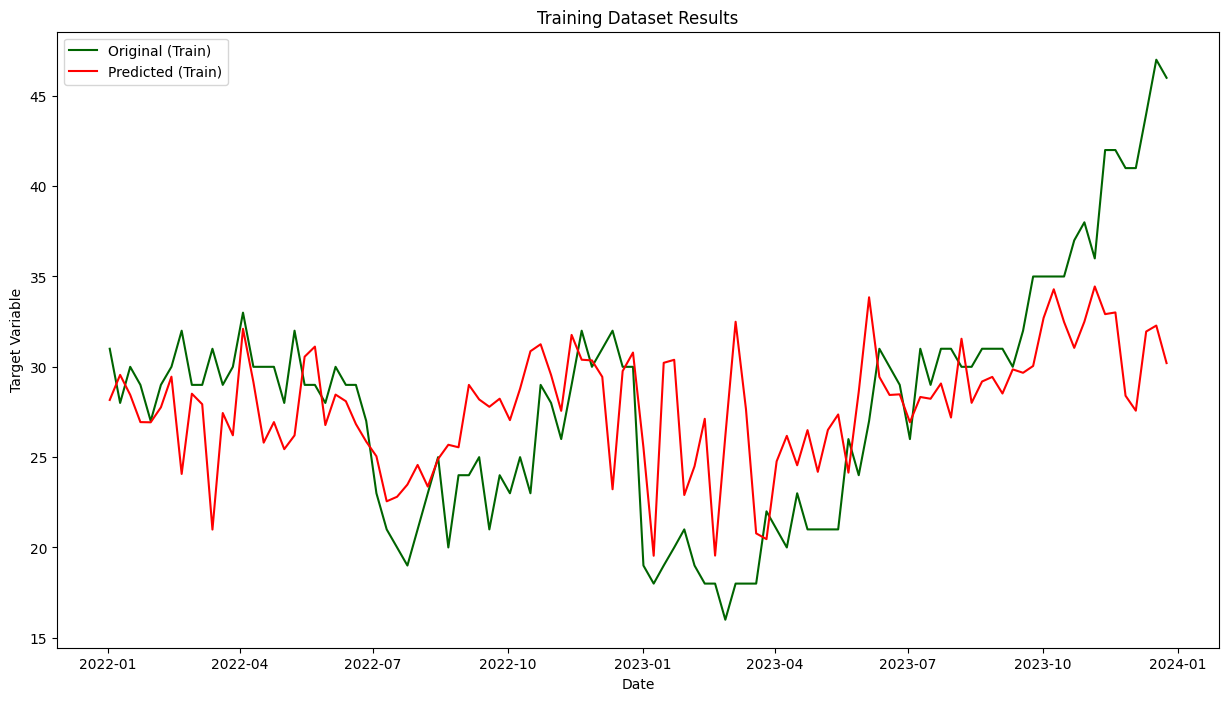

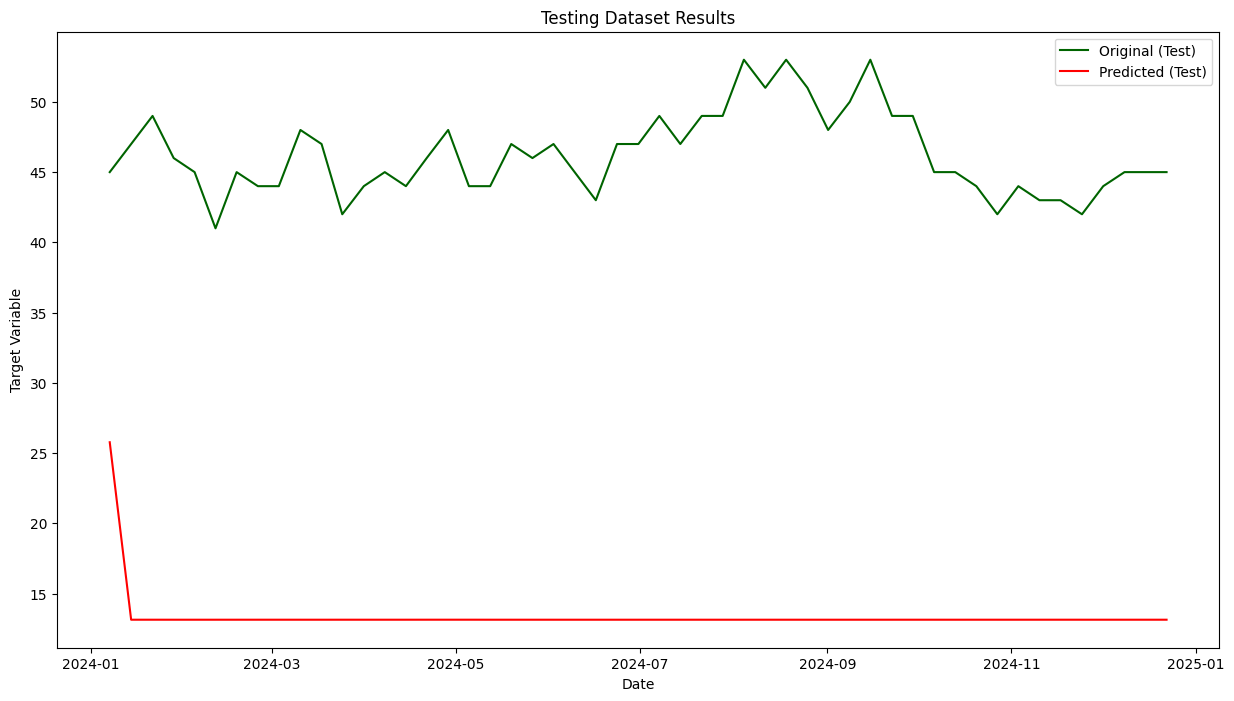

In [93]:
test_fun(model_c)

#Forecast

In [98]:
def forecast(model):
  # Number of future time steps to forecast
  future_steps = 52  # Adjust this as needed

  # Last `TIME_STEPS` values from the test set to start forecasting
  last_sequence = X_test[-1]

  # Forecast future values
  future_forecast = []
  for _ in range(future_steps):
      # Predict next value based on the last sequence
      next_pred = model.predict(last_sequence.reshape(1, -1))
      future_forecast.append(next_pred[0])
      # Update the last sequence by removing the first element and adding the predicted value
      last_sequence = np.roll(last_sequence, -1)
      last_sequence[-1] = next_pred

  # Inverse scaling for future forecast
  future_forecast_inv = scaler[1].inverse_transform(np.array(future_forecast).reshape(-1, 1))

  # Generate future timestamps
  last_date = df.index[-1]
  future_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='W')[1:]
  print(future_dates,future_forecast_inv)
  # Plotting the future forecast
  plt.figure(figsize=(15, 8))
  plt.plot(df.index, df['Population'], label='Historical Data', color='darkgreen')
  plt.plot(future_dates, future_forecast_inv, label='Future Forecast', color='blue')
  plt.xlabel('Date')
  plt.ylabel('Population Density')
  plt.title('Population Density Future Forecast with SVR')
  plt.legend()
  plt.show()


DatetimeIndex(['2025-01-05 06:14:56', '2025-01-12 06:14:56',
               '2025-01-19 06:14:56', '2025-01-26 06:14:56',
               '2025-02-02 06:14:56', '2025-02-09 06:14:56',
               '2025-02-16 06:14:56', '2025-02-23 06:14:56',
               '2025-03-02 06:14:56', '2025-03-09 06:14:56',
               '2025-03-16 06:14:56', '2025-03-23 06:14:56',
               '2025-03-30 06:14:56', '2025-04-06 06:14:56',
               '2025-04-13 06:14:56', '2025-04-20 06:14:56',
               '2025-04-27 06:14:56', '2025-05-04 06:14:56',
               '2025-05-11 06:14:56', '2025-05-18 06:14:56',
               '2025-05-25 06:14:56', '2025-06-01 06:14:56',
               '2025-06-08 06:14:56', '2025-06-15 06:14:56',
               '2025-06-22 06:14:56', '2025-06-29 06:14:56',
               '2025-07-06 06:14:56', '2025-07-13 06:14:56',
               '2025-07-20 06:14:56', '2025-07-27 06:14:56',
               '2025-08-03 06:14:56', '2025-08-10 06:14:56',
               '2025-08-

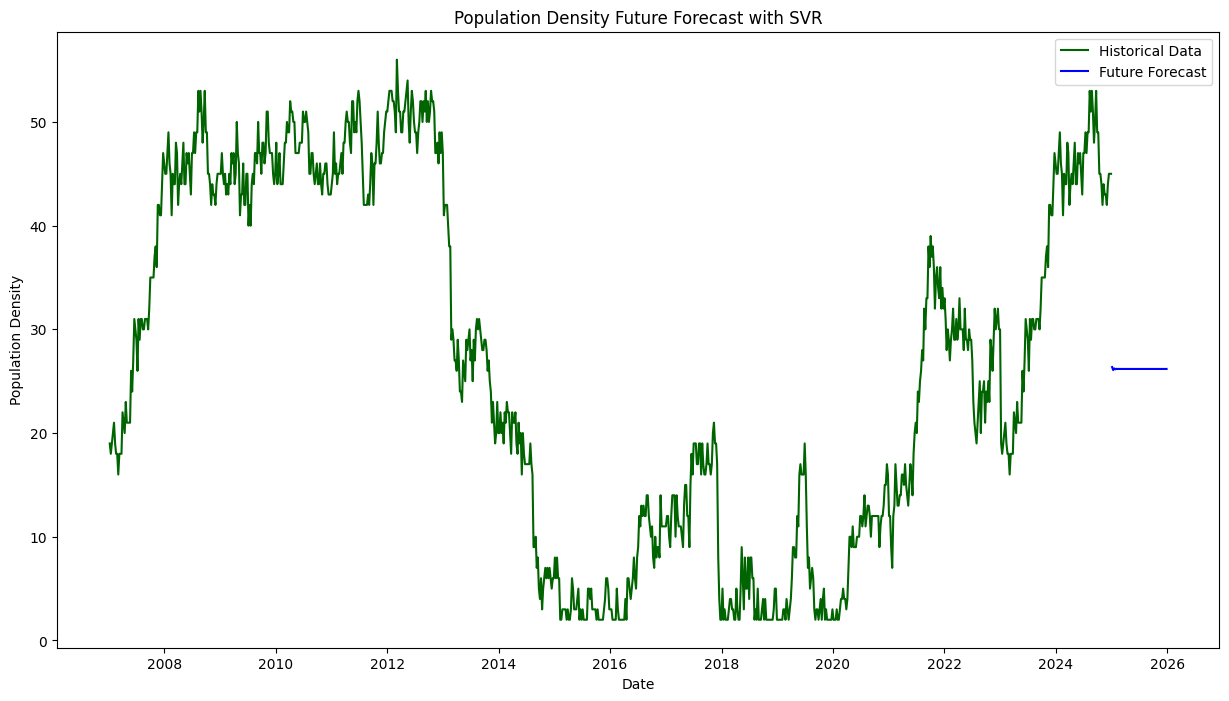

In [99]:
forecast(model_q)

DatetimeIndex(['2025-01-05 06:14:56', '2025-01-12 06:14:56',
               '2025-01-19 06:14:56', '2025-01-26 06:14:56',
               '2025-02-02 06:14:56', '2025-02-09 06:14:56',
               '2025-02-16 06:14:56', '2025-02-23 06:14:56',
               '2025-03-02 06:14:56', '2025-03-09 06:14:56',
               '2025-03-16 06:14:56', '2025-03-23 06:14:56',
               '2025-03-30 06:14:56', '2025-04-06 06:14:56',
               '2025-04-13 06:14:56', '2025-04-20 06:14:56',
               '2025-04-27 06:14:56', '2025-05-04 06:14:56',
               '2025-05-11 06:14:56', '2025-05-18 06:14:56',
               '2025-05-25 06:14:56', '2025-06-01 06:14:56',
               '2025-06-08 06:14:56', '2025-06-15 06:14:56',
               '2025-06-22 06:14:56', '2025-06-29 06:14:56',
               '2025-07-06 06:14:56', '2025-07-13 06:14:56',
               '2025-07-20 06:14:56', '2025-07-27 06:14:56',
               '2025-08-03 06:14:56', '2025-08-10 06:14:56',
               '2025-08-

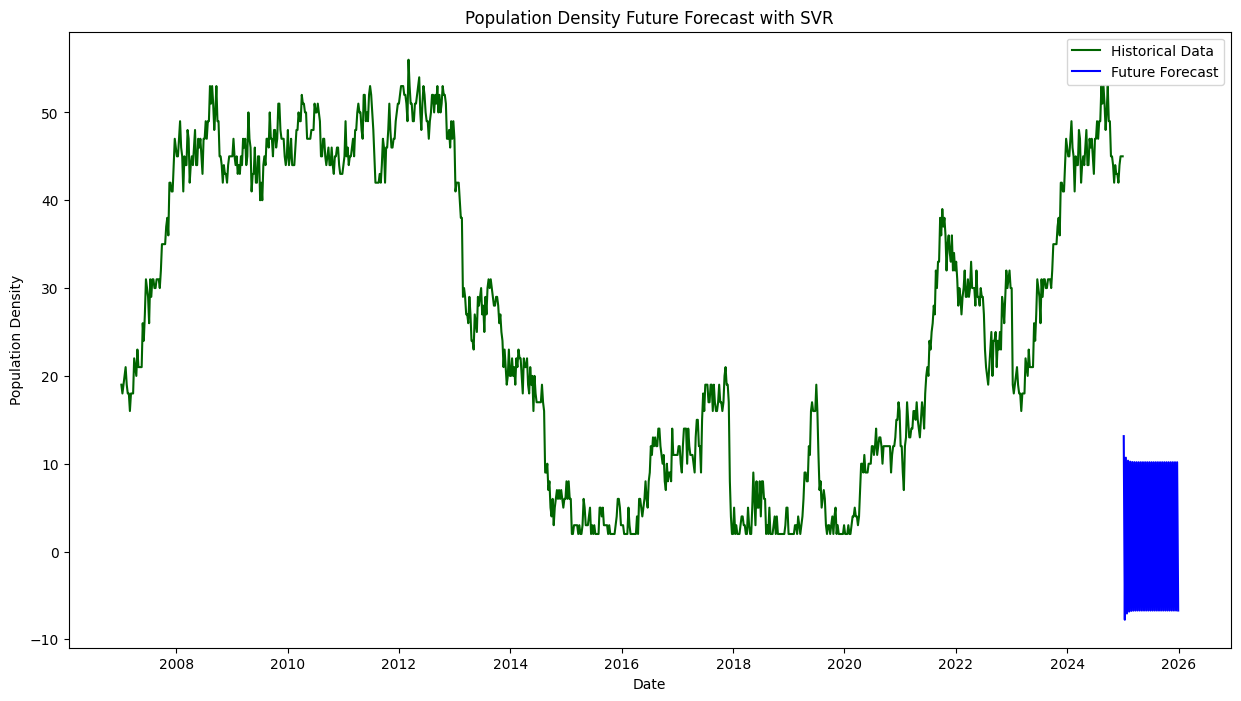

In [100]:
forecast(model_c)